In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 200
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 0.5005
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,100),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Ut = rungeKutta(u, Ut, Uf, h, t, lbda)
        D = np.linalg.norm(Ut-Uf)**2
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Ut, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        rho_vector[0][t] = pt[0][0]
        rho_vector[1][t] = pt[0][1]
        rho_vector[2][t] = pt[1][0]
        rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Ut, np.transpose(Ut)))+np.abs(np.trace(np.dot(np.transpose(Uf), Ut)))**2)/(3*(3+1)))
        if t%5 == 0:
            resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
        t += 1
    
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector

In [20]:
portas = []
estados = []
distancia = []

i = 1

fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector = main()
portas.append(sum(fid_autores[30:])/(len(fid_autores)-30))
estados.append(sum(fid_vector[30:])/(len(fid_vector)-30))
distancia.append(sum(distance_vector[80:])/(len(distance_vector)-80))

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

Valores de média na iteração 1:
Portas: 0.9949606854145856
Estados: (0.9972122787946502+1.4907148124776498e-06j)
Distância: 4.5240917922008894e-06
 


In [21]:
fid_vector

[np.clongdouble('0.4999997320317598591+0.00014517197448408618795j'),
 np.clongdouble('0.5001190999201595948-4.0260017742708211163e-07j'),
 np.clongdouble('0.5000857432056138124+8.763863654955455259e-05j'),
 np.clongdouble('0.50008383217180229737+8.4891670281728483904e-05j'),
 np.clongdouble('0.49999908674427321733+3.6894089185532437537e-05j'),
 np.clongdouble('0.49999865023420276538+1.39892158656764052185e-08j'),
 np.clongdouble('0.54332906018229900475+0.00020881772443966529035j'),
 np.clongdouble('0.579765554978241755+1.1606383452664245595e-12j'),
 np.clongdouble('0.5985772982903308194+0.00016705044034166073549j'),
 np.clongdouble('0.6057873817264713345-5.6737800528292128672e-13j'),
 np.clongdouble('0.6081971335731833549-0.0002504657266602158866j'),
 np.clongdouble('0.78930410622329586623+0.00020490610423526982087j'),
 np.clongdouble('0.90357102663114172527+0.00014031726687206055425j'),
 np.clongdouble('0.95162024108094945326+1.9681670353215245494e-14j'),
 np.clongdouble('0.9741550588

In [22]:
fid_autores

[np.float64(0.33177345340558295),
 np.float64(0.3235546364837192),
 np.float64(0.2958736006132631),
 np.float64(0.26483660066327314),
 np.float64(0.24994170522878176),
 np.float64(0.26021012029731777),
 np.float64(0.3051439283132864),
 np.float64(0.3662061401449652),
 np.float64(0.40348680412465615),
 np.float64(0.4163911981323247),
 np.float64(0.4206782692314153),
 np.float64(0.6367288773811254),
 np.float64(0.8174089183367402),
 np.float64(0.9036785545586213),
 np.float64(0.9463491001427973),
 np.float64(0.9684915213609858),
 np.float64(0.9684877179394813),
 np.float64(0.9684839143442391),
 np.float64(0.9684801105752939),
 np.float64(0.9684763066326809),
 np.float64(0.9684725025164344),
 np.float64(0.9711495254173848),
 np.float64(0.9717268253616466),
 np.float64(0.9718477290449665),
 np.float64(0.9718691058446344),
 np.float64(0.9718687760149171),
 np.float64(0.9718679668480142),
 np.float64(0.971867145584883),
 np.float64(0.9718663122613503),
 np.float64(0.9718654669135788),
 np.fl

In [23]:
rho_vector

array([[ 5.00000000e-01+0.00000000e+00j,  4.99974997e-01+0.00000000e+00j,
         4.99998254e-01+0.00000000e+00j,  4.99999025e-01+0.00000000e+00j,
         4.99998874e-01+0.00000000e+00j,  4.99998611e-01+0.00000000e+00j,
         5.43252420e-01+0.00000000e+00j,  5.79602265e-01+0.00000000e+00j,
         5.98577624e-01+0.00000000e+00j,  6.05462326e-01+0.00000000e+00j,
         6.08152689e-01+0.00000000e+00j,  7.89304452e-01+0.00000000e+00j,
         9.03460206e-01+0.00000000e+00j,  9.51516290e-01+0.00000000e+00j,
         9.74155611e-01+0.00000000e+00j,  9.85656722e-01+0.00000000e+00j,
         9.85653195e-01+0.00000000e+00j,  9.85649668e-01+0.00000000e+00j,
         9.85646141e-01+0.00000000e+00j,  9.85642614e-01+0.00000000e+00j,
         9.85639087e-01+0.00000000e+00j,  9.85634267e-01+0.00000000e+00j,
         9.85629449e-01+0.00000000e+00j,  9.85624631e-01+0.00000000e+00j,
         9.85619814e-01+0.00000000e+00j,  9.85614996e-01+0.00000000e+00j,
         9.85612979e-01+0.00000000e+00

In [24]:
sum(distance_vector[30:])/(len(distance_vector)-30)

np.float64(0.018924052774781968)

In [25]:
distance_vector

[np.float64(7.9811932072647656),
 np.float64(7.8791159087277505),
 np.float64(7.484557753257289),
 np.float64(6.846694686583045),
 np.float64(6.074925893147009),
 np.float64(5.29103122641491),
 np.float64(4.367610917412917),
 np.float64(3.6334497589535193),
 np.float64(3.2831326305416138),
 np.float64(3.1722800322384175),
 np.float64(3.1363825084066894),
 np.float64(1.690162742052615),
 np.float64(0.780096954900441),
 np.float64(0.39783412278982916),
 np.float64(0.21799124089015884),
 np.float64(0.12680725443937316),
 np.float64(0.12679592782156116),
 np.float64(0.12678460246373377),
 np.float64(0.1267732783657417),
 np.float64(0.12676195552743566),
 np.float64(0.12675063394866634),
 np.float64(0.11597434925498255),
 np.float64(0.11363157032631907),
 np.float64(0.11312010985527104),
 np.float64(0.11300792077666688),
 np.float64(0.11298280702140409),
 np.float64(0.11295925749483453),
 np.float64(0.11293575782456645),
 np.float64(0.11291230786443056),
 np.float64(0.11288890746689259),
 n

In [26]:
fx_vector

[np.float64(137.1717730127981),
 np.float64(-0.0028492177654750165),
 np.float64(-0.0014619465912436578),
 np.float64(-0.000986964185474115),
 np.float64(-0.0006807345974665951),
 np.float64(-0.0003931535978164901),
 np.float64(-5.409510478175577e-05),
 np.float64(0.00019027826750527785),
 np.float64(0.0003360425765483653),
 np.float64(0.00038870229248137445),
 np.float64(0.00040474125186274444),
 400,
 np.float64(239.7672167647543),
 np.float64(148.45445314737185),
 np.float64(100.27562964612096),
 np.float64(70.84701379806492),
 np.float64(0.011441148062060346),
 np.float64(0.011440561020962107),
 np.float64(0.011439974031451012),
 np.float64(0.011439387093523004),
 np.float64(0.011438800207174022),
 np.float64(0.00020423149882781096),
 np.float64(0.0002050962611448809),
 np.float64(0.00020548176578505725),
 np.float64(0.00020568879916094105),
 np.float64(0.00020582265900246773),
 np.float64(0.0002058550673307524),
 np.float64(0.00020589389283146803),
 np.float64(0.000205932812289869

In [27]:
fy_vector

[np.float64(0.0),
 np.float64(-0.22296032502168284),
 np.float64(-0.005688861324408552),
 np.float64(-0.0017896435327334934),
 np.float64(-0.0007404434170417706),
 np.float64(-0.00028410954579799133),
 400,
 np.float64(394.15173435864915),
 np.float64(211.21450437499738),
 np.float64(113.6574157322495),
 np.float64(63.503987868933855),
 np.float64(0.004552675183933058),
 np.float64(0.0028496458534506717),
 np.float64(0.0017482818870658478),
 np.float64(0.0010846004553442972),
 np.float64(0.0006679367578443571),
 np.float64(0.0006745324951874999),
 np.float64(0.0006747319457293122),
 np.float64(0.0006749314115405311),
 np.float64(0.0006751308926231839),
 np.float64(0.0006753303889792956),
 np.float64(0.0006211550110727309),
 np.float64(0.0006017431008031698),
 np.float64(0.00059298202153398),
 np.float64(0.0005890418131010653),
 np.float64(0.000587319118938372),
 np.float64(0.08075322933434845),
 np.float64(0.08066515825154369),
 np.float64(0.0805772595466396),
 np.float64(0.08048953680

In [28]:
fz_vector

[np.float64(0.0),
 np.float64(329.7308320906885),
 400,
 400,
 400,
 400,
 np.float64(-8.191038495899526e-05),
 np.float64(0.0005123159700257218),
 np.float64(0.001822040408487282),
 np.float64(0.004501319714974481),
 np.float64(0.011198280835457831),
 np.float64(0.006649134198829866),
 np.float64(0.0031546207698321047),
 np.float64(0.001657705462678241),
 np.float64(0.0009274584653342263),
 np.float64(0.0005293643742215174),
 np.float64(0.0005350284565678569),
 np.float64(0.0005351783931321314),
 np.float64(0.0005353283365734651),
 np.float64(0.0005354782868924492),
 np.float64(0.0005356282440896723),
 np.float64(26.54081043144285),
 np.float64(12.397862141389695),
 np.float64(5.796460465656138),
 np.float64(2.7153596396263433),
 np.float64(1.282926149429801),
 np.float64(0.025009411953267863),
 np.float64(0.02550034702754334),
 np.float64(0.026018145156461035),
 np.float64(0.02656535011237563),
 np.float64(0.02714485616001007),
 np.float64(-0.015484248554520137),
 np.float64(-0.00899

In [29]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.030, 0.050)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [30]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [31]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [32]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

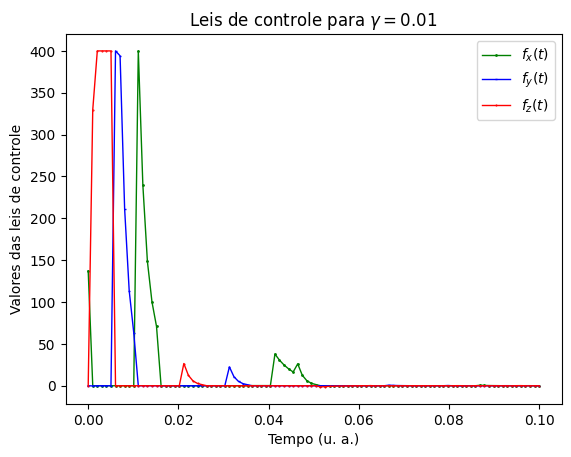

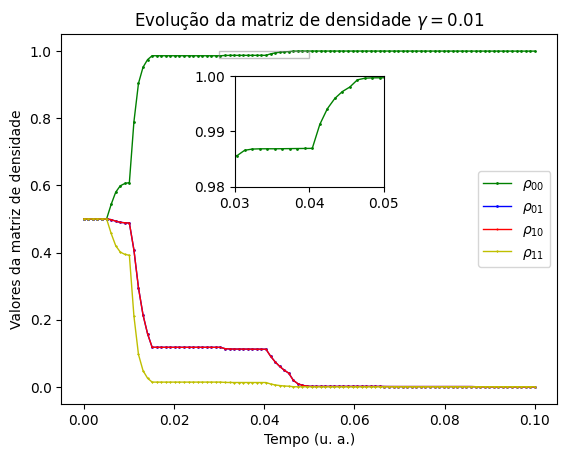

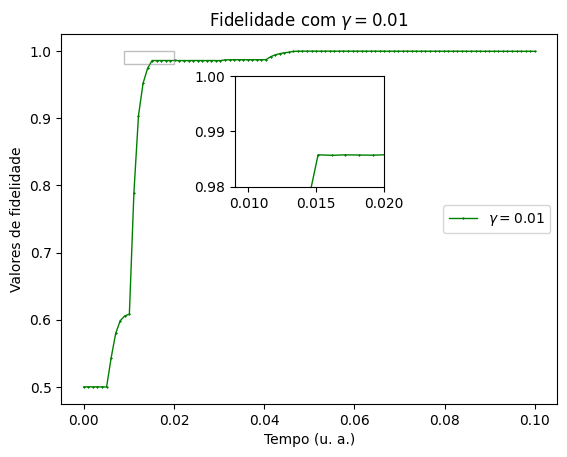

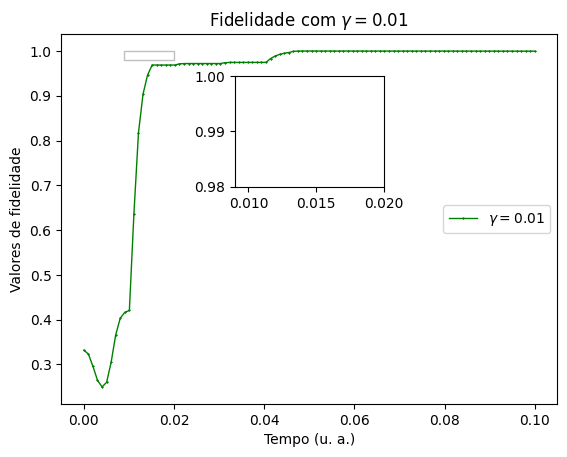

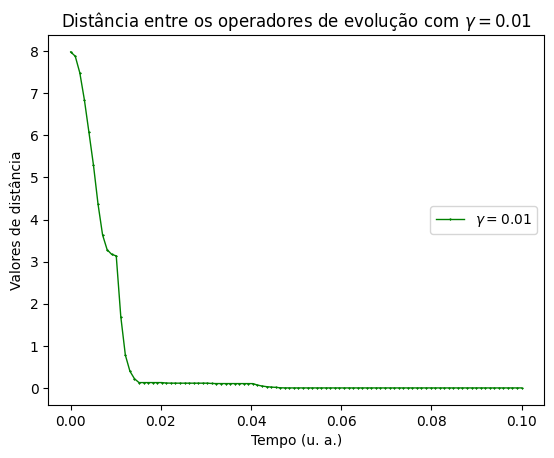

In [33]:
t = 100
lbda = 0.01
leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
densidade(rho_vector,t,lbda)
fidelidade(fid_vector,t,lbda)
fidelidade(fid_autores,t,lbda)
distance(distance_vector,t,lbda)